In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
# import glib.pyplotdefs as pd
from const_mesolve import *

/usr/lib/python3.11/site-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


Single mode and $\phi=0$ for simplicity:

$$
H = \omega_{01}\left|1\right>\left<1\right|+\omega_m\sum_n\left|n\right>\left<n\right|+\frac{\Omega}{2}(e^{-i(kx-\omega t)}\left|0\right>\left<1\right|+h.c.) = H_0+H'\\
H_0 = \omega\left|1\right>\left<1\right|,\\ H' = \omega_m\sum_n\left|n\right>\left<n\right|+\frac{\Omega}{2}(e^{-i(kx-\omega t)}\left|0\right>\left<1\right|+h.c.)+\delta\left|1\right>\left<1\right|
$$
with $\delta=\omega_{01}-\omega$. In interaction picture:
$$
H'(t) = e^{iH_0t}H'e^{-iH_0t} = \omega_m\sum_n\left|n\right>\left<n\right| + \frac{\Omega}{2}(e^{-i\eta(a+a^\dagger)}\left|0\right>\left<1\right|+h.c.)+\delta\left|1\right>\left<1\right|
$$
with $\eta=\frac{2\pi}{\lambda}\sqrt{\frac{\hbar}{2m\omega_m}}$.

In [2]:
nMax = 50
omega = 2e6*np.pi*0.025
eta = 2*np.pi/(578e-9)*np.sqrt(1.05e-34/(2*171*1.67e-27*omega))
eta

0.3718908150999969

In [3]:
def Rabi(Omega=1, w=omega, nbar=0, LD=eta, num_pi=4, det=0, num_points=201):
    LD = 2*np.pi/(578e-9)*np.sqrt(1.05e-34/(2*171*1.67e-27*(w*1e6)))
    H = w*tensor(qeye(2), num(nMax)) + Omega/2*(tensor(sigmap(), (-1j*LD*(create(nMax)+destroy(nMax))).expm())
                  + tensor(sigmam(), (1j*LD*(create(nMax)+destroy(nMax))).expm()))+det*tensor(fock_dm(2, 1), qeye(nMax))
    
    init = tensor(fock_dm(2, 0), thermal_dm(nMax, nbar))
    tList = np.linspace(0, num_pi*np.pi/Omega, num_points)
    
    meas = [tensor(fock_dm(2, 0), qeye(nMax)), 
            tensor(fock_dm(2, 1), qeye(nMax)),
            tensor(qeye(2), num(nMax)), 
            tensor(qeye(2), fock_dm(nMax, 0))]
    result = const_mesolve(H, init, tList, [], meas).expect
    
    return tList, result[0], result[1], result[2], result[3]

In [4]:
k_B = 1.38e-23
hbar = 1.06e-34

In [5]:
Omega_ = 2*np.pi*0.13
w_ = 2*np.pi*0.01
T = 8e-6
nbar_ = k_B*T/hbar/w_/1e6
# nbar_ = 5

t, amp0, amp1, navg, n0 = Rabi(Omega=Omega_, 
                        w=w_, 
                        nbar=nbar_, 
                        num_pi=10,
                        # det=20*w_
                       )

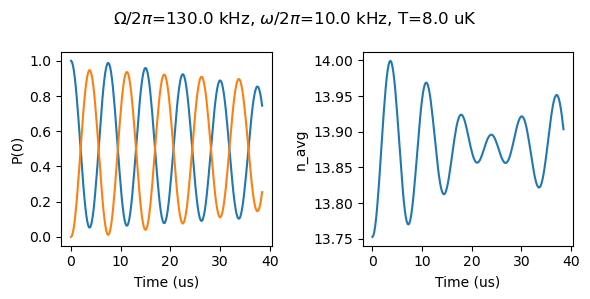

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].plot(t, amp0)
ax[0].plot(t, amp1)
ax[0].set_xlabel('Time (us)')
ax[0].set_ylabel('P(0)')
ax[1].plot(t, navg)
ax[1].set_xlabel('Time (us)')
ax[1].set_ylabel('n_avg')

fig.suptitle(f'$\Omega/2\pi$={Omega_*1e3/2/np.pi:.1f} kHz, $\omega/2\pi$={w_*1e3/2/np.pi:.1f} kHz, T={1e6*T:.1f} uK')
plt.tight_layout()

# plt.savefig(f'T={1e6*T:.1f}uK_w={w_*1e3/2/np.pi:.1f}kHz_Omega={Omega_*1e3/2/np.pi:.1f}kHz.png')

In [7]:
# detuning scan
Omega_ = 2*np.pi*0.002
w_ = 2*np.pi*0.01
det_list = np.linspace(-2*w_, 2*w_, 41)
num_pi_ = 0.5

# T = 8e-6
# nbar_ = k_B*T/hbar/w_/1e6*0
nbar_ = 7

amp0_list = np.array([Rabi(Omega=Omega_, 
                           w=w_, 
                           nbar=nbar_, 
                           num_pi=num_pi_,
                           det=d_, num_points=2)[1][-1] for d_ in det_list])

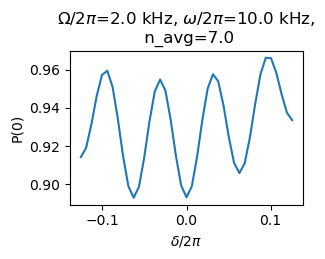

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(det_list, amp0_list)
ax.set_xlabel('$\delta/2\pi$')
ax.set_ylabel('P(0)')
ax.set_title(f'$\Omega/2\pi$={Omega_*1e3/2/np.pi:.1f} kHz, $\omega/2\pi$={w_*1e3/2/np.pi:.1f} kHz,\n n_avg={nbar_:.1f}')

plt.savefig('detuning_scan.png')

In [9]:
# amp0_list

In [10]:
(1-amp0_list[30])/(amp0_list[30]-amp0_list[10])

7.284309333975997

In [191]:
def Rabi_tt(Omega=1, w=omega, nbar=0, LD=eta, t_wait=0):
    LD = 2*np.pi/(578e-9)*np.sqrt(1.05e-34/(2*171*1.67e-27*(w*1e6)))
    H_I = w*tensor(qeye(2), num(nMax)) + Omega/2*(tensor(sigmap(), (-1j*LD*(create(nMax)+destroy(nMax))).expm())
                  + tensor(sigmam(), (1j*LD*(create(nMax)+destroy(nMax))).expm()))
    
    H_id = w*tensor(qeye(2), num(nMax))
    def H_I_coeff(t, args):
        if t<np.pi/Omega/2 or t>np.pi/Omega/2+t_wait:
            return 1
        else:
            return 0
    def H_id_coeff(t, args):
        if t>np.pi/Omega/2 and t<np.pi/Omega/2+t_wait:
            return 1
        else:
            return 0
    H = [[H_I, H_I_coeff], [H_id, H_id_coeff]]
    
    init = tensor(fock_dm(2, 0), thermal_dm(nMax, nbar))
    tList = np.linspace(0, 1*np.pi/Omega+t_wait, 101)
#     # print(tList)
    meas = [tensor(fock_dm(2, 1), qeye(nMax))]
    result = mesolve(H, init, tList, [], meas).expect[0][-1]
    
    return t_wait, result

In [192]:
Omega_ = 2*np.pi*1
w_ = 2*np.pi*0.03
nbar_ = 10
LD_ = eta

In [197]:
t_id_list = np.linspace(0, 40, 31)
fid_list = np.array([Rabi_tt(Omega=Omega_, w=w_, nbar=nbar_, LD=LD_, t_wait=t)[1] for t in t_id_list])

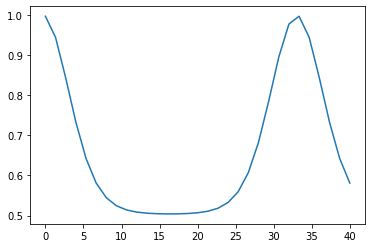

In [198]:
plt.plot(t_id_list, fid_list)

In [252]:
expect(num(nMax), thermal_dm(nMax, 8))

7.637020313296268

In [213]:
# def H_(Omega=1, w=omega, nbar=0, LD=eta):
#     nMax=4
#     LD = 2*np.pi/(578e-9)*np.sqrt(1.05e-34/(2*171*1.67e-27*(w*1e6)))
#     H = w*tensor(qeye(2), num(nMax)) + Omega/2*(tensor(sigmap(), (-1j*LD*(create(nMax)+destroy(nMax))).expm())
#                   + tensor(sigmam(), (1j*LD*(create(nMax)+destroy(nMax))).expm()))
    
#     return H.full()

In [214]:
# plt.plot()
# plt.imshow(np.real(H_(Omega=1, w=0.1)))

In [250]:
1-5e-5

0.99995

In [6]:
k_B = 1.38e-23
hbar = 1.06e-34

In [7]:
np.exp(-hbar*2*np.pi*130e3/k_B/46.7e-6)/(1-np.exp(-hbar*2*np.pi*130e3/k_B/46.7e-6))

6.9545156168952715

In [24]:
130/160

0.8125

In [29]:
np.exp(-hbar*2*np.pi*20e3/k_B/5e-6)/(1-np.exp(-hbar*2*np.pi*20e3/k_B/5e-6))

4.696120358306819